Team: Nathan Pham, 	Sriram Rampelli, 	Priyatham Chadalawada

The automated identification of anomalies in spinal imaging, namely neural foraminal constriction and spinal canal stenosis, was the main emphasis of the RSNA competition. This required processing and analyzing a large set of DICOM images, where the primary goal was to classify spine conditions as normal, moderate, or severe. Convolutional neural networks (CNNs) and using Dense Neural Networks which in this case, we used DNN for Model 1, a type of deep learning model, were employed by our team to extract characteristics from the DICOM pictures. To guarantee consistency, we performed specialized preparation operations such as data normalization and scaling. The different sizes and levels of complexity in the photos made the dataset difficult to work with, but with careful treatment of this heterogeneity, we were able to train a reliable model.

Our group was able to extract important metadata from the spinal investigations and load and handle the large-scale DICOM pictures in an organized manner utilizing the code that was built. This was especially crucial because managing numerous target labels for every spinal segment was required for the competition. With distinct mappings between the photos and their labels, the technology also allowed the team to effectively produce and manage many classes of anomalies. Achieving a high validation accuracy of over 95% was largely due to the deployment of multi-class classification, picture warping for model input, and image normalization. Additionally, we learnt how to fine-tune the classification through training optimization utilizing cross-entropy loss and adaptive learning rates.

Our team learned a great deal about handling the complexity of DICOM formats and working with medical imaging data as a result of this approach. They also gained knowledge on how to create scalable and effective pipelines for big datasets while striking a balance between model complexity and accuracy. The process also demonstrated the value of careful data preprocessing, wise model architecture choices, and ongoing performance tracking using metrics like classification reports and confusion matrices, which were essential in determining the model's strengths and areas for development.

Improving the model's performance using more sophisticated designs, such convolutional neural networks (CNNs) made especially for medical picture processing, would be one area of focus for future research. Better feature extraction and more precise predictions may result from this, especially when it comes to recognizing subtle variations in spinal disorders. Furthermore, adding more varied datasets from other healthcare facilities could enhance the model's generalizability across a range of imaging devices and patient types. Using transfer learning techniques on medical imaging tasks using pre-trained models is another possible avenue to speed up training and maybe improve performance.

The present model's primary drawback is its exclusive focus on a single deep learning architecture, with no consideration given to ensemble techniques. Combining the predictions from several models into an ensemble might lower variation and increase the findings' resilience. Another drawback is that, despite the model's high accuracy, it could not be enough for clinical applications where incorrect categorization could result in unsuitable treatment choices. To make this model work in a real-world healthcare context, it is imperative to improve the precision and recall for all categories, especially the more severe instances.

The dataset itself also presents difficulties because labeling is based on human annotations, which might bring errors and irregularities. This is particularly important for medical datasets, since even small mislabeling can result in large model mistakes. To fully realize the potential of the proposed model, these issues would need to be addressed by improved data curation, automated labeling methods, or larger datasets.

In [ ]:
import os
import pandas as pd
import numpy as np
import pydicom
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from skimage.transform import resize
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
import matplotlib.image as mpimg
from tensorflow.keras.models import load_model

# Example of File data:

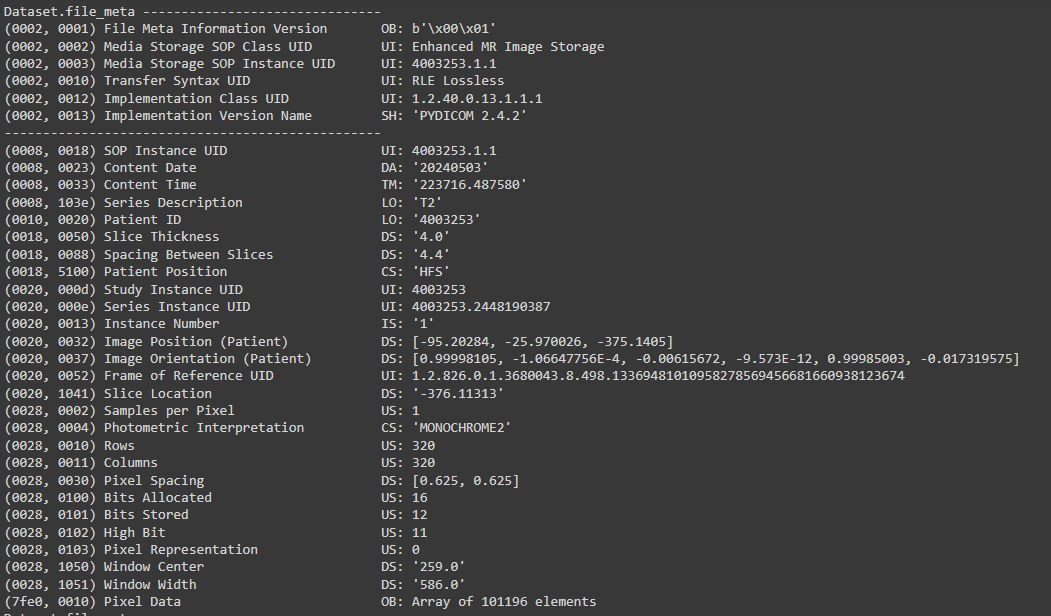

In [ ]:
# Load the CSV file
train_csv = pd.read_csv('C:/Users/laphm/Documents/Code/train.csv')

# Example CSV columns to use (adjust based on your data)
print(train_csv.columns)

# Initialize paths
train_images_path = 'C:/Users/laphm/Documents/Code/train_images'

# Set target image size to 256x256 due to the variety of different image sizes
target_image_size = (256, 256)

Index(['study_id', 'spinal_canal_stenosis_l1_l2',
       'spinal_canal_stenosis_l2_l3', 'spinal_canal_stenosis_l3_l4',
       'spinal_canal_stenosis_l4_l5', 'spinal_canal_stenosis_l5_s1',
       'left_neural_foraminal_narrowing_l1_l2',
       'left_neural_foraminal_narrowing_l2_l3',
       'left_neural_foraminal_narrowing_l3_l4',
       'left_neural_foraminal_narrowing_l4_l5',
       'left_neural_foraminal_narrowing_l5_s1',
       'right_neural_foraminal_narrowing_l1_l2',
       'right_neural_foraminal_narrowing_l2_l3',
       'right_neural_foraminal_narrowing_l3_l4',
       'right_neural_foraminal_narrowing_l4_l5',
       'right_neural_foraminal_narrowing_l5_s1',
       'left_subarticular_stenosis_l1_l2', 'left_subarticular_stenosis_l2_l3',
       'left_subarticular_stenosis_l3_l4', 'left_subarticular_stenosis_l4_l5',
       'left_subarticular_stenosis_l5_s1', 'right_subarticular_stenosis_l1_l2',
       'right_subarticular_stenosis_l2_l3',
       'right_subarticular_stenosis_l3_l4',
 

In [ ]:
# Initialize variables
image_data = []
labels = []
image_metadata = []
skipped_images_count = 0  # Count of images skipped due to missing labels

# Traverse the folder structure
for study_folder in tqdm(os.listdir(train_images_path)):
    study_path = os.path.join(train_images_path, study_folder)
    if os.path.isdir(study_path):
        for series_folder in os.listdir(study_path):
            series_path = os.path.join(study_path, series_folder)
            if os.path.isdir(series_path):
                for image_file in os.listdir(series_path):
                    if image_file.endswith('.dcm'):
                        # Read DICOM file
                        dcm_path = os.path.join(series_path, image_file)
                        dicom_image = pydicom.dcmread(dcm_path).pixel_array

                        # Resize image to a fixed size (256x256)
                        resized_image = resize(dicom_image, target_image_size, anti_aliasing=True)

                        # Extract label for the corresponding study
                        study_id = int(study_folder)
                        label_row = train_csv[train_csv['study_id'] == study_id]

                        if not label_row.empty:
                            # Select appropriate label column(s)
                            label = label_row['spinal_canal_stenosis_l1_l2'].values[0]  # Example column

                            if pd.notna(label):  # Ensure the label is not missing (NaN)
                                # Append image, label, and metadata
                                image_data.append(resized_image)
                                labels.append(label)
                                image_metadata.append({'study_id': study_id, 'series_id': series_folder, 'image_file': image_file})
                            else:
                                skipped_images_count += 1
                        else:
                            skipped_images_count += 1

# Convert lists to numpy arrays
image_data = np.array(image_data)
labels = np.array(labels)

# Normalize images
image_data = image_data / 255.0

# Show example mapping of images to labels
print("\nSample Image Data Shape:", image_data.shape)
print("\nSample Labels:", labels[:10])  # Display first 10 labels
print("\nSample Metadata (first 5):", image_metadata[:5])  # Display metadata for first 5 images


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [10:56<00:00,  1.64s/it]



Sample Image Data Shape: (30140, 256, 256)

Sample Labels: ['Normal/Mild' 'Normal/Mild' 'Normal/Mild' 'Normal/Mild' 'Normal/Mild'
 'Normal/Mild' 'Normal/Mild' 'Normal/Mild' 'Normal/Mild' 'Normal/Mild']

Sample Metadata (first 5): [{'study_id': 100206310, 'series_id': '1012284084', 'image_file': '1.dcm'}, {'study_id': 100206310, 'series_id': '1012284084', 'image_file': '10.dcm'}, {'study_id': 100206310, 'series_id': '1012284084', 'image_file': '11.dcm'}, {'study_id': 100206310, 'series_id': '1012284084', 'image_file': '12.dcm'}, {'study_id': 100206310, 'series_id': '1012284084', 'image_file': '13.dcm'}]


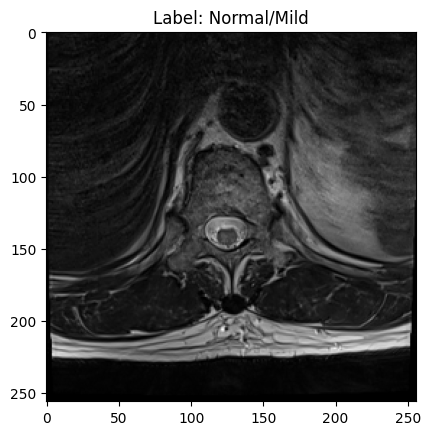

Image 1 Path: 1.dcm, Label: Normal/Mild
Image 2 Path: 10.dcm, Label: Normal/Mild
Image 3 Path: 11.dcm, Label: Normal/Mild
Image 4 Path: 12.dcm, Label: Normal/Mild
Image 5 Path: 13.dcm, Label: Normal/Mild

Total number of images: 30140
Total number of labeled images: 30140
Total number of skipped images: 0


In [ ]:
plt.imshow(image_data[0], cmap='gray')
plt.title(f"Label: {labels[0]}")
plt.show()

# Show the first few entries in the arrays for verification
for i in range(5):
    print(f"Image {i+1} Path: {image_metadata[i]['image_file']}, Label: {labels[i]}")

# Print total counts
total_images = len(image_metadata) + skipped_images_count
print(f"\nTotal number of images: {total_images}")
print(f"Total number of labeled images: {len(labels)}")
print(f"Total number of skipped images: {skipped_images_count}")

In [ ]:
def count_total_images_and_labels(image_dir):
    # Get all class labels (folders)
    class_labels = os.listdir(image_dir)

    # Initialize counters
    total_labels = len(class_labels)
    total_images = 0

    # Iterate over each class label
    for label in class_labels:
        label_dir = os.path.join(image_dir, label)

        # Get list of images for this label
        images = os.listdir(label_dir)
        num_label_images = len(images)

        # Update total image count
        total_images += num_label_images

    # Print the total number of labels and images
    print(f"Total number of labels: {total_labels}")
    print(f"Total number of images: {total_images}")

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(image_data, labels_encoded, test_size=0.2, random_state=42)

# Reshape data to fit the model, and because  the images are grayscale, we need to add an extra dimension
X_train = X_train.reshape(-1, 256, 256, 1)
X_test = X_test.reshape(-1, 256, 256, 1)

In [ ]:
# Convert labels to categorical (for multi-class classification)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
model = Sequential([
    Flatten(input_shape=(256, 256, 1)),  # Flatten the 3D image into 1D
    Dense(128, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')  # Replace num_classes with the number of classes
])

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

Epoch 1/10
754/754 ━━━━━━━━━━━━━━━━━━━━ 56s 71ms/step - accuracy: 0.9409 - loss: 0.4234 - val_accuracy: 0.9494 - val_loss: 0.2274
Epoch 2/10
754/754 ━━━━━━━━━━━━━━━━━━━━ 36s 48ms/step - accuracy: 0.9451 - loss: 0.2385 - val_accuracy: 0.9494 - val_loss: 0.2219
Epoch 3/10
754/754 ━━━━━━━━━━━━━━━━━━━━ 35s 47ms/step - accuracy: 0.9500 - loss: 0.2186 - val_accuracy: 0.9494 - val_loss: 0.2179
Epoch 4/10
754/754 ━━━━━━━━━━━━━━━━━━━━ 35s 46ms/step - accuracy: 0.9500 - loss: 0.2138 - val_accuracy: 0.9521 - val_loss: 0.2137
Epoch 5/10
754/754 ━━━━━━━━━━━━━━━━━━━━ 35s 46ms/step - accuracy: 0.9515 - loss: 0.2112 - val_accuracy: 0.9516 - val_loss: 0.2100
Epoch 6/10
754/754 ━━━━━━━━━━━━━━━━━━━━ 35s 47ms/step - accuracy: 0.9497 - loss: 0.2119 - val_accuracy: 0.9521 - val_loss: 0.2051
Epoch 7/10
754/754 ━━━━━━━━━━━━━━━━━━━━ 35s 46ms/step - accuracy: 0.9507 - loss: 0.2050 - val_accuracy: 0.9517 - val_loss: 0.2025
Epoch 8/10
754/754 ━━━━━━━━━━━━━━━━━━━━ 35s 46ms/step - accuracy: 0.9532 - loss: 0.1914 - 

In [ ]:
# Save the model
model_save_path = 'C:/Users/laphm/Documents/Code/50_percent_trained_model.h5'  # Adjust the path as needed
model.save(model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to C:/Users/laphm/Documents/Code/50_percent_trained_model.h5


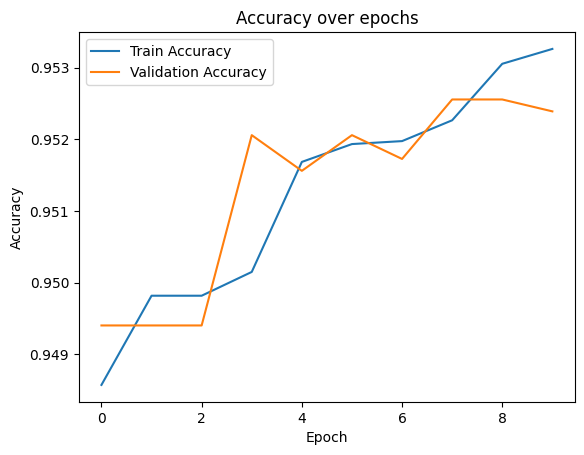

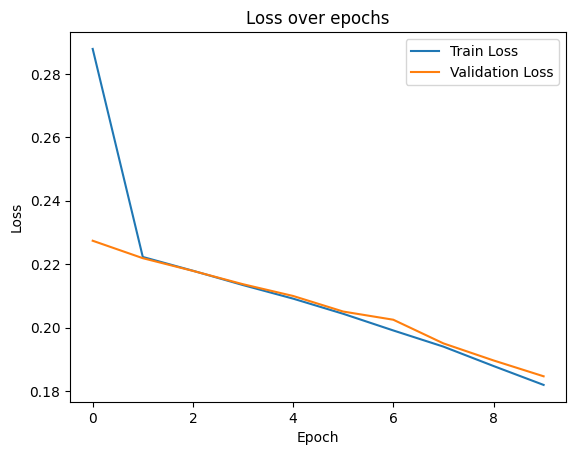

In [ ]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over epochs')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over epochs')
plt.show()

Note: we are using multiclassification due to the amount types of spines to observe

In [ ]:
X_val = X_test
y_val = y_test

# Predict on validation set
y_pred = model.predict(X_val)

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert y_val (one-hot encoded) to class labels
y_val_classes = np.argmax(y_val, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_val_classes, y_pred_classes)

num_classes = conf_matrix.shape[0]

# Loop through each class and calculate TP, FN, FP, TN
for i in range(num_classes):
    TP = conf_matrix[i, i]
    FN = conf_matrix[i, :].sum() - TP
    FP = conf_matrix[:, i].sum() - TP
    TN = conf_matrix.sum() - (TP + FP + FN)

    print(f"Class {i}:")
    print(f"  True Positives (TP): {TP}")
    print(f"  False Negatives (FN): {FN}")
    print(f"  False Positives (FP): {FP}")
    print(f"  True Negatives (TN): {TN}")

189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Class 0:
  True Positives (TP): 15
  False Negatives (FN): 193
  False Positives (FP): 0
  True Negatives (TN): 5820
Class 1:
  True Positives (TP): 5722
  False Negatives (FN): 1
  False Positives (FP): 286
  True Negatives (TN): 19
Class 2:
  True Positives (TP): 4
  False Negatives (FN): 93
  False Positives (FP): 1
  True Negatives (TN): 5930


In [ ]:
# Load the saved model
model_path = 'C:/Users/laphm/Documents/Code/50_percent_trained_model.h5'

# Initialize paths for test images
test_images_path = 'C:/Users/laphm/Documents/Code/test_images'

# Initialize list for test images and their metadata
test_image_data = []
test_image_metadata = []

In [ ]:
# Traverse the folder structure of the test images
for study_folder in tqdm(os.listdir(test_images_path)):
    study_path = os.path.join(test_images_path, study_folder)
    if os.path.isdir(study_path):
        for series_folder in os.listdir(study_path):
            series_path = os.path.join(study_path, series_folder)
            if os.path.isdir(series_path):
                for image_file in os.listdir(series_path):
                    if image_file.endswith('.dcm'):
                        # Read DICOM file
                        dcm_path = os.path.join(series_path, image_file)
                        dicom_image = pydicom.dcmread(dcm_path).pixel_array

                        # Resize image to the target size
                        resized_image = resize(dicom_image, target_image_size, anti_aliasing=True)

                        # Normalize the image
                        resized_image = resized_image / 255.0

                        # Append the image and metadata
                        test_image_data.append(resized_image)
                        test_image_metadata.append({'study_id': study_folder, 'series_id': series_folder, 'image_file': image_file})

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]


In [ ]:
# Convert test images to numpy array and reshape to match model input
test_image_data = np.array(test_image_data)
test_image_data = test_image_data.reshape(-1, 256, 256, 1)

In [ ]:
# Predict the classes for the test images
predictions = model.predict(test_image_data)

# Decode the predictions back into the original labels (conditions and spine parts)
predicted_labels = label_encoder.inverse_transform(np.argmax(predictions, axis=1))

sorted_metadata = sorted(test_image_metadata, key=lambda x: (x['study_id'], x['image_file']))

# Iterate over the sorted metadata and print folder and prediction info
for i, metadata in enumerate(sorted_metadata):
    print(f"Study: {metadata['study_id']} | Series: {metadata['series_id']} | Image: {metadata['image_file']} | Predicted Condition & Spine Part: {predicted_labels[i]}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Study: 44036939 | Series: 2828203845 | Image: 1.dcm | Predicted Condition & Spine Part: Moderate
Study: 44036939 | Series: 3481971518 | Image: 1.dcm | Predicted Condition & Spine Part: Moderate
Study: 44036939 | Series: 3844393089 | Image: 1.dcm | Predicted Condition & Spine Part: Moderate
Study: 44036939 | Series: 2828203845 | Image: 10.dcm | Predicted Condition & Spine Part: Moderate
Study: 44036939 | Series: 3481971518 | Image: 10.dcm | Predicted Condition & Spine Part: Moderate
Study: 44036939 | Series: 3844393089 | Image: 10.dcm | Predicted Condition & Spine Part: Moderate
Study: 44036939 | Series: 2828203845 | Image: 11.dcm | Predicted Condition & Spine Part: Moderate
Study: 44036939 | Series: 3481971518 | Image: 11.dcm | Predicted Condition & Spine Part: Moderate
Study: 44036939 | Series: 3844393089 | Image: 11.dcm | Predicted Condition & Spine Part: Moderate
Study: 44036939 | Series: 2828203845 | Image: 12.dcm | Predicted Condition & Spine 

In [ ]:
predicted_probs = model.predict(test_image_data)

# Sort test_image_metadata by 'study_id' and 'image_file' for orderly output
sorted_metadata = sorted(test_image_metadata, key=lambda x: (x['study_id'], x['image_file']))

# Output probabilities for each image in a sorted manner
for i, metadata in enumerate(sorted_metadata):
    print(f"Study: {metadata['study_id']} | Series: {metadata['series_id']} | Image: {metadata['image_file']} | Predicted Probabilities: {predicted_probs[i]}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Study: 44036939 | Series: 2828203845 | Image: 1.dcm | Predicted Probabilities: [0.01944944 0.97362006 0.00693055]
Study: 44036939 | Series: 3481971518 | Image: 1.dcm | Predicted Probabilities: [0.04496541 0.93554896 0.01948565]
Study: 44036939 | Series: 3844393089 | Image: 1.dcm | Predicted Probabilities: [0.04935091 0.9289071  0.02174198]
Study: 44036939 | Series: 2828203845 | Image: 10.dcm | Predicted Probabilities: [0.05359106 0.9220421  0.02436685]
Study: 44036939 | Series: 3481971518 | Image: 10.dcm | Predicted Probabilities: [0.0489561  0.92934275 0.02170122]
Study: 44036939 | Series: 3844393089 | Image: 10.dcm | Predicted Probabilities: [0.03886982 0.94338524 0.01774489]
Study: 44036939 | Series: 2828203845 | Image: 11.dcm | Predicted Probabilities: [0.03138383 0.95452726 0.01408888]
Study: 44036939 | Series: 3481971518 | Image: 11.dcm | Predicted Probabilities: [0.03459821 0.94968677 0.01571503]
Study: 44036939 | Series: 3844393089 | Image: